#Goal of these project:
#a.Choose the stock(s) or indices you want to focus on (e.g., Apple, Tesla, S&P 500).
#b.Predict the next day’s closing price.
#c.Forecast prices for the next week/month.
#d.Predict stock trends (e.g., up/down).



In [ ]:
!pip install pandas openpyxl
#!pip install requests

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Checking whether the Google Drive path exists or not

In [ ]:
!ls -l "/content/drive/My Drive/Stock Price Prediction Project/DataSet"

total 705540
-rw------- 1 root root 147033850 Feb  3 04:28 SnP_daily_update.csv
-rw------- 1 root root  99822247 Jun 17 05:18 SnP_daily_update.xlsx
-rw------- 1 root root 168825836 Jun 24 05:46 stock_data_long_filled.csv
-rw------- 1 root root 166846261 Jun 24 05:46 stock_data_long_nonempty.csv
-rw------- 1 root root 139943382 Jun 24 05:45 stock_data_wide.csv


#Checking whether the file exist or not

In [ ]:
import os
file_path = '/content/drive/My Drive/Stock Price Prediction Project/DataSet/SnP_daily_update.xlsx'
print("file_path exists :",os.path.exists(file_path))

file_path exists : True


#Importing the libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load & Explore the Data (EDA)


In [ ]:
#Read Excel with multi-row headers (ticker and field)
df_stock_rawData = pd.read_excel(file_path, header=[0, 1]) # Read first 2 rows as header

In [ ]:
print(df_stock_rawData.shape)

(3795, 2516)


In [ ]:
print(df_stock_rawData.columns.tolist())

[('Price', 'Ticker'), ('Close', 'A'), ('Close', 'AAPL'), ('Close', 'ABBV'), ('Close', 'ABNB'), ('Close', 'ABT'), ('Close', 'ACGL'), ('Close', 'ACN'), ('Close', 'ADBE'), ('Close', 'ADI'), ('Close', 'ADM'), ('Close', 'ADP'), ('Close', 'ADSK'), ('Close', 'AEE'), ('Close', 'AEP'), ('Close', 'AES'), ('Close', 'AFL'), ('Close', 'AIG'), ('Close', 'AIZ'), ('Close', 'AJG'), ('Close', 'AKAM'), ('Close', 'ALB'), ('Close', 'ALGN'), ('Close', 'ALL'), ('Close', 'ALLE'), ('Close', 'AMAT'), ('Close', 'AMCR'), ('Close', 'AMD'), ('Close', 'AME'), ('Close', 'AMGN'), ('Close', 'AMP'), ('Close', 'AMT'), ('Close', 'AMZN'), ('Close', 'ANET'), ('Close', 'ANSS'), ('Close', 'AON'), ('Close', 'AOS'), ('Close', 'APA'), ('Close', 'APD'), ('Close', 'APH'), ('Close', 'APO'), ('Close', 'APTV'), ('Close', 'ARE'), ('Close', 'ATO'), ('Close', 'AVB'), ('Close', 'AVGO'), ('Close', 'AVY'), ('Close', 'AWK'), ('Close', 'AXON'), ('Close', 'AXP'), ('Close', 'AZO'), ('Close', 'BA'), ('Close', 'BAC'), ('Close', 'BALL'), ('Close'

In [ ]:
# Flatten the MultiIndex columns Example: ('AAPL', 'Open') --> 'AAPL_Open'
new_columns = []
for field, ticker in df_stock_rawData.columns:
    if field.lower() == 'price':  # This is the first column: 'Date'
        new_columns.append("Date")
    else:
        new_columns.append(f"{ticker}_{field}")

In [ ]:
df_stock_rawData.columns = new_columns
print(df_stock_rawData.columns)

Index(['Date', 'A_Close', 'AAPL_Close', 'ABBV_Close', 'ABNB_Close',
       'ABT_Close', 'ACGL_Close', 'ACN_Close', 'ADBE_Close', 'ADI_Close',
       ...
       'WTW_Volume', 'WY_Volume', 'WYNN_Volume', 'XEL_Volume', 'XOM_Volume',
       'XYL_Volume', 'YUM_Volume', 'ZBH_Volume', 'ZBRA_Volume', 'ZTS_Volume'],
      dtype='object', length=2516)


In [ ]:
print(df_stock_rawData['Date'].head(10))

0                   Date
1    2010-01-04 00:00:00
2    2010-01-05 00:00:00
3    2010-01-06 00:00:00
4    2010-01-07 00:00:00
5    2010-01-08 00:00:00
6    2010-01-11 00:00:00
7    2010-01-12 00:00:00
8    2010-01-13 00:00:00
9    2010-01-14 00:00:00
Name: Date, dtype: object


#Identify Inconsistent Date Format Entries in the data (if any)

In [ ]:
parsed_dates = pd.to_datetime(df_stock_rawData['Date'],  errors='coerce')

#Find rows where parsing failed(NaT returned)
invalid_dates = df_stock_rawData[parsed_dates.isna()]

print("Rows with invalid/misformatted dates: ")
print(invalid_dates[['Date']].head())

Rows with invalid/misformatted dates: 
   Date
0  Date


/tmp/ipython-input-11-492326642.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed_dates = pd.to_datetime(df_stock_rawData['Date'],  errors='coerce')


In [ ]:
#Drop the first row which contains old header text (like 'Date')
df_stock_rawData = df_stock_rawData.iloc[1:].reset_index(drop=True)

# Ensure Date column is datetime type format='%Y-%m-%d',
df_stock_rawData['Date'] = pd.to_datetime(df_stock_rawData['Date'], format='%Y-%m-%d', errors='coerce')

print("Rows with formatted dates: ")
print(df_stock_rawData['Date'].head(10))

Rows with formatted dates: 
0   2010-01-04
1   2010-01-05
2   2010-01-06
3   2010-01-07
4   2010-01-08
5   2010-01-11
6   2010-01-12
7   2010-01-13
8   2010-01-14
9   2010-01-15
Name: Date, dtype: datetime64[ns]


In [ ]:
# Drop rows where Date is NaT (in case of junk rows)
df_clean = df_stock_rawData[df_stock_rawData['Date'].notna()].reset_index(drop=True)

In [ ]:
#Final sanity check
print("Shape:", df_clean.shape)
print("Sample columns:", df_clean.columns[:10])
print(df_clean.head())

Shape: (3794, 2516)
Sample columns: Index(['Date', 'A_Close', 'AAPL_Close', 'ABBV_Close', 'ABNB_Close',
       'ABT_Close', 'ACGL_Close', 'ACN_Close', 'ADBE_Close', 'ADI_Close'],
      dtype='object')
        Date    A_Close  AAPL_Close  ABBV_Close  ABNB_Close  ABT_Close  \
0 2010-01-04  20.016031    6.447413         NaN         NaN  18.665760   
1 2010-01-05  19.798611    6.458559         NaN         NaN  18.514954   
2 2010-01-06  19.728262    6.355827         NaN         NaN  18.617779   
3 2010-01-07  19.702684    6.344077         NaN         NaN  18.772013   
4 2010-01-08  19.696289    6.386254         NaN         NaN  18.867979   

   ACGL_Close  ACN_Close  ADBE_Close  ADI_Close  ...  WTW_Volume  WY_Volume  \
0    7.601905  31.941788   37.090000  22.258945  ...    348017.0  1832400.0   
1    7.576549  32.139217   37.700001  22.223806  ...    339523.0  1724500.0   
2    7.543795  32.480865   37.619999  22.181639  ...    585049.0  2254400.0   
3    7.499420  32.450500   36.889999  

In [ ]:
ticker = 'AAPL'  # Change this to any other ticker as needed

# Select columns that match the ticker plus the Date
ticker_columns = ['Date'] + [col for col in df_clean.columns if col.startswith(f"{ticker}_")]

# Create the filtered DataFrame
df_ticker = df_clean[ticker_columns]

# Show the first few rows
print(df_ticker.head())

        Date  AAPL_Close  AAPL_High  AAPL_Low  AAPL_Open  AAPL_Volume
0 2010-01-04    6.447413   6.462175  6.398307   6.429940  493729600.0
1 2010-01-05    6.458559   6.495012  6.424515   6.465187  601904800.0
2 2010-01-06    6.355827   6.484167  6.349199   6.458559  552160000.0
3 2010-01-07    6.344077   6.386858  6.297983   6.379326  477131200.0
4 2010-01-08    6.386254   6.386857  6.298285   6.335641  447610800.0


In [ ]:
#Code to Convert Wide → Long Format
"""
Use long when(df_long_full):
==========================
You need to group by ticker and apply functions (groupby, rolling, etc.).
You’re doing ML training where each row is a training sample.
You need tidy data for libraries like seaborn, plotly, or ML tools.

Use wide when (df_clean):
=========================
You want to visualize multiple time series side-by-side (e.g., AAPL, MSFT Close prices on same graph).
You’re preparing for correlation analysis or matrix computations.
Pandas .rolling(), .diff() etc. across time per ticker.
"""

# 1. Melt the dataframe: unpivot all columns except Date
"""It "unpivots" your data so that each row contains:
A Date
A TickerField (e.g., AAPL_Close, MSFT_High, etc.)
A Value (e.g., 176.3, 255.6, etc.)
"""
df_melted = df_clean.melt(id_vars=["Date"], var_name="TickerField", value_name="Value")

# 2. Extract Ticker and Field names (from columns like AAPL_Close)
df_melted[['Ticker', 'Field']] = df_melted['TickerField'].str.extract(r'^(.*?)_(Open|High|Low|Close|Volume)$')

# 3. Drop rows where extraction failed (bad column names)
df_melted = df_melted.dropna(subset=['Ticker', 'Field'])

# 4. Pivot so each row has Date, Ticker, Open, High, Low, Close, Volume
df_long_actual = df_melted.pivot_table(index=['Date', 'Ticker'], columns='Field', values='Value').reset_index()

In [ ]:
# 5. Create the FULL grid of Date × Ticker combinations
all_dates = pd.to_datetime(df_clean['Date'].unique())

# set(...) — removes duplicates → gives you unique tickers , sorted(...) — puts them in alphabetical order.
all_tickers = sorted(set(df_melted['Ticker']))

"""all_dates: a list or array of all unique dates from your data
from_product(...): creates the Cartesian product of all dates × all tickers — i.e., every possible combination of Date and Ticker.
to_frame(index=False): converts it into a normal DataFrame (not a MultiIndex), with two columns: Date, Ticker.
This ensures that every Ticker has a row for every Date, even if its data is missing (NaN) """
full_grid = pd.MultiIndex.from_product([all_dates, all_tickers], names=["Date", "Ticker"]).to_frame(index=False)

# 6. Merge to ensure all combinations are kept (missing fields will be NaN)
df_long_full = pd.merge(full_grid, df_long_actual, on=["Date", "Ticker"], how="left")

# 7. (Optional) Sort for readability
df_long_full = df_long_full.sort_values(['Ticker', 'Date']).reset_index(drop=True)

In [ ]:
print(df_long_full.head())

        Date Ticker      Close       High        Low       Open     Volume
0 2010-01-04      A  20.016031  20.227063  19.907317  20.073585  3815561.0
1 2010-01-05      A  19.798611  19.964878  19.670712  19.958484  4186031.0
2 2010-01-06      A  19.728262  19.824185  19.670707  19.728262  3243779.0
3 2010-01-07      A  19.702684  19.709079  19.504442  19.683498  3095172.0
4 2010-01-08      A  19.696289  19.728265  19.440495  19.593971  3733918.0


In [ ]:
print(df_long_full.shape)

(1908382, 7)


#Confirm Total Data Points Match

In [ ]:
#Each ticker in the wide format has 5 fields: Open, High, Low, Close, Volume.
#So the expected number of data points in the long format is:
#If these two match → ✅ no data is lost or duplicated during the melt & pivot.
expected_data_points = (df_clean.shape[0]) * len([col for col in df_clean.columns if col != 'Date'])  # i.e., total non-date cells
actual_data_points = df_long_full[['Open', 'High', 'Low', 'Close', 'Volume']].count().sum()
print(f"Expected: {expected_data_points}, Actual: {actual_data_points}")


Expected: 9541910, Actual: 9059285


#Confirm Number of Tickers and Dates

In [ ]:
#If both checks are True → ✅ no extra tickers or dates were introduced or lost.
# Original tickers
tickers_from_wide = sorted({col.split('_')[0] for col in df_clean.columns if col != 'Date'})
tickers_from_long = sorted(df_long_full['Ticker'].unique().tolist())
print("Tickers match?", tickers_from_wide == tickers_from_long)

# Dates
dates_from_wide = sorted(df_clean['Date'].dropna().unique())
dates_from_long = sorted(df_long_full['Date'].dropna().unique())
print("Dates match?", np.array_equal(dates_from_wide, dates_from_long))

Tickers match? True
Dates match? True


#Comparison of Unique Date and Ticker Counts

In [ ]:
# Unique dates and tickers in the original cleaned wide data
raw_dates = pd.to_datetime(df_clean['Date']).unique()
raw_tickers = sorted({col.split('_')[0] for col in df_clean.columns if '_' in col})

In [ ]:
# Unique dates and tickers in long-form dataset
long_dates = df_long_full['Date'].unique()
long_tickers = df_long_full['Ticker'].unique()

In [ ]:
# Check counts
print("Unique Dates (Raw):", len(raw_dates))
print("Unique Dates (Long):", len(long_dates))
print("Match?", set(raw_dates) == set(long_dates))

print("Unique Tickers (Raw):", len(raw_tickers))
print("Unique Tickers (Long):", len(long_tickers))
print("Match?", set(raw_tickers) == set(long_tickers))

Unique Dates (Raw): 3794
Unique Dates (Long): 3794
Match? True
Unique Tickers (Raw): 503
Unique Tickers (Long): 503
Match? True


#Confirm Total Rows in Long Format

In [ ]:
#If they match → ✅ the Cartesian product was created correctly.
expected_rows = len(dates_from_wide) * len(tickers_from_wide)
print(f"Expected rows: {expected_rows}, Actual rows: {df_long_full.shape[0]}")

Expected rows: 1908382, Actual rows: 1908382


#Check for Duplicate Date-Ticker Pairs

In [ ]:
#If this prints 0 → ✅ no duplicates, which is correct.
duplicate_pairs = df_long_full.duplicated(subset=['Date', 'Ticker']).sum()
print("Duplicate (Date, Ticker) rows:", duplicate_pairs)

Duplicate (Date, Ticker) rows: 0


# Check if All Expected Ticker-Field Columns Were Present

In [ ]:
#If some fields are missing (like Volume), that explains the drop in data points.
expected_fields = ['Open', 'High', 'Low', 'Close', 'Volume']

# Get all unique field parts from wide format
ticker_fields_wide = [col for col in df_clean.columns if col != 'Date']
ticker_field_types = sorted(set(col.split('_')[1] for col in ticker_fields_wide if '_' in col))

print("Unique field types in wide format:", ticker_field_types)
print("Missing expected fields:", set(expected_fields) - set(ticker_field_types))

Unique field types in wide format: ['Close', 'High', 'Low', 'Open', 'Volume']
Missing expected fields: set()


#Check How Many Columns Were Extracted and Retained During Melt

In [ ]:
print("Total columns in wide format (excluding Date):", len(df_clean.columns) - 1)
print("Total rows in df_melted:", df_melted.shape[0])
print("Unique combinations in df_melted['TickerField']:", df_melted['TickerField'].nunique())

Total columns in wide format (excluding Date): 2515
Total rows in df_melted: 9541910
Unique combinations in df_melted['TickerField']: 2515


In [ ]:
"""
| Check                                                 | Output                                       | Interpretation                            |
| ----------------------------------------------------- | -------------------------------------------- | ----------------------------------------- |
| **Unique field types**                                | `['Close', 'High', 'Low', 'Open', 'Volume']` | ✅ All 5 expected fields are present       |
| **Missing expected fields**                           | `set()`                                      | ✅ None missing                            |
| **Wide format columns (excluding Date)**              | `2515`                                       | ✅ You have 2515 ticker-field columns      |
| **Melted rows**                                       | `9,541,910`                                  | ✅ Correct: 2515 × number of rows (\~3794) |
| **Unique combinations in `df_melted['TickerField']`** | `2515`                                       | ✅ Nothing dropped during melt             |

🧠 Interpretation
We did not lose any columns during melt or reshape — all data points made it into df_melted.
So where did the mismatch in long format (df_long_full) come from?

🧪 Next Check: Where the Data Drops then?
After melting, you're performing this:
df_melted[['Ticker', 'Field']] = df_melted['TickerField'].str.extract(r'^(.*?)_(Open|High|Low|Close|Volume)$')
df_melted = df_melted.dropna(subset=['Ticker', 'Field'])  # <- HERE might be the silent drop

This drops rows where the pattern TICKER_Field didn't match.
But since we confirmed all 2515 were extracted successfully from TickerField, the drop is likely minimal or non-existent.

"""

In [ ]:
"""
✅ Total Value Counts at Each Step
Let’s walk through this line by line to ensure data point consistency:
| Step                         | Data Points                              | What It Represents                                       |
| ---------------------------- | ---------------------------------------- | -------------------------------------------------------- |
| ✅ Wide Format                | 3794 rows × 2515 columns = **9,541,910** | Raw data                                                 |
| ✅ Melted Format              | **9,541,910** rows                       | Each value converted into one row                        |
| ✅ After Ticker/Field Extract | Still 9.54M rows                         | No loss reported                                         |
| ❌ Final `df_long_full` shape | **1,908,382** rows                       | Only one row per (Date, Ticker) pair with pivoted fields |

🔍 Where the Data Loss Happens
df_long_actual = df_melted.pivot_table(index=['Date', 'Ticker'], columns='Field', values='Value').reset_index()
This gives you:
One row per (Date, Ticker)
And five columns: Open, High, Low, Close, Volume

→ So:
Total rows = Dates × Tickers = 503 × 3794 = 1,908,382
✅ Which exactly matches your df_long_full.

This means:
✅ We didn’t lose data. We reshaped it.
The raw 9.5M cells are now spread across five columns in a longer but narrower DataFrame.

🔁 Why the Drop from 9.5M to 1.9M?
| Format                       | Description                    | Rows | Columns                      |
| ---------------------------- | ------------------------------ | ---- | ---------------------------- |
| **Wide**                     | All values in separate columns | 3794 | 2515                         |
| **Melted**                   | Long row for every cell        | 9.5M | 3 (Date, TickerField, Value) |
| **Pivoted (`df_long_full`)** | One row per (Date, Ticker)     | 1.9M | 7 (Date, Ticker, 5 fields)   |

This is not a data loss, it's a reshaping.

"""

#Final Confirmation on the data loss

In [ ]:
# Melt then pivot then re-count number of values .If these are close (within ~0.5%), then all is well.
total_values_in_long = df_long_full[['Open', 'High', 'Low', 'Close', 'Volume']].count().sum()

print("Total non-null values in df_long_full:", total_values_in_long)
print("Total values originally (non-null):", df_melted['Value'].notna().sum())

Total non-null values in df_long_full: 9059285
Total values originally (non-null): 9059285


In [ ]:
"""
🧾 Final Summary:
| Check                                    | Value         | Meaning                          |
| ---------------------------------------- | ------------- | -------------------------------- |
| **Original total values (non-null)**     | **9,059,285** | From wide → melt step            |
| **Final total values in `df_long_full`** | **9,059,285** | After melt → pivot merge         |
| **Difference**                           | `0`           | ✅ No data was lost or duplicated |

So We have successfully:
Read the multi-index wide Excel data
Melted it into tidy long format
Extracted clean ticker/field pairs
Pivoted back into per-date-per-ticker rows with field columns
Verified no information was lost
"""

#Diagnose the Missing Data

> Add blockquote

> Add blockquote





In [ ]:
# See which columns have missing values and how many For df_clean (Wide Format):
missing_counts = df_clean.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts.head(10))  # top 10 columns with missing values

SW_Close      3650
SW_High       3650
SW_Open       3650
SW_Volume     3650
SW_Low        3650
GEV_Volume    3583
GEV_Close     3583
SOLV_Open     3583
GEV_High      3583
SOLV_High     3583
dtype: int64


In [ ]:
# Check rows with missing values For df_long (Long Format):
print(df_long_full[df_long_full.isna().any(axis=1)].head())

# Count missing per field
print(df_long_full.isna().sum())

           Date Ticker  Close  High  Low  Open  Volume
7588 2010-01-04   ABBV    NaN   NaN  NaN   NaN     NaN
7589 2010-01-05   ABBV    NaN   NaN  NaN   NaN     NaN
7590 2010-01-06   ABBV    NaN   NaN  NaN   NaN     NaN
7591 2010-01-07   ABBV    NaN   NaN  NaN   NaN     NaN
7592 2010-01-08   ABBV    NaN   NaN  NaN   NaN     NaN
Date          0
Ticker        0
Close     96525
High      96525
Low       96525
Open      96525
Volume    96525
dtype: int64


In [ ]:
#Drop Ticker-Date Pairs with No Data at All:
df_nonempty = df_long_full.dropna(subset=["Close", "Open", "High", "Low", "Volume"], how="all")
print(df_nonempty[df_nonempty.isna().any(axis=1)].head())

# Count missing per field
print(df_nonempty.isna().sum())

Empty DataFrame
Columns: [Date, Ticker, Close, High, Low, Open, Volume]
Index: []
Date      0
Ticker    0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


#| DataFrame      | Use Case                                                        |
| ---------------------- | --------------------------------------------------------------- |
#| `df_clean`     | Original format for BI tools, exports, feature generation       |
#| `df_long_full` | Full record, allows understanding missing patterns, gap-filling |
#| `df_nonempty`  | Clean, ready-to-use dataset for modeling, plotting, forecasting |


In [ ]:
# How many nulls per ticker
null_stats = df_long_full.groupby("Ticker")[["Close", "Open", "High", "Low", "Volume"]].apply(lambda df: df.isna().sum())
print(null_stats.sort_values("Close", ascending=False).head(10))

        Close  Open  High   Low  Volume
Ticker                                 
SW       3650  3650  3650  3650    3650
SOLV     3583  3583  3583  3583    3583
GEV      3583  3583  3583  3583    3583
VLTO     3461  3461  3461  3461    3461
KVUE     3356  3356  3356  3356    3356
GEHC     3261  3261  3261  3261    3261
CEG      3032  3032  3032  3032    3032
ABNB     2754  2754  2754  2754    2754
PLTR     2704  2704  2704  2704    2704
CARR     2569  2569  2569  2569    2569


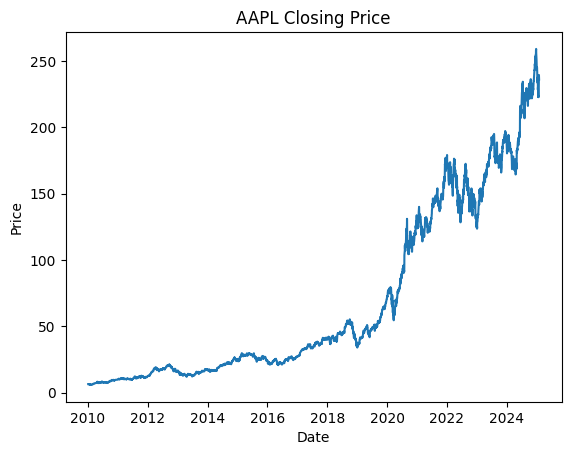

In [ ]:
# Plot closing prices for AAPL
df_aapl = df_nonempty[df_nonempty["Ticker"] == "AAPL"]
plt.plot(df_aapl["Date"], df_aapl["Close"])
plt.title("AAPL Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [ ]:
print("Missing values before ffill:")
print(df_long_full[['Close', 'High', 'Low', 'Open', 'Volume']].isna().sum())

Missing values before ffill:
Close     96525
High      96525
Low       96525
Open      96525
Volume    96525
dtype: int64


In [ ]:
print(df_long_full[(df_long_full['Ticker'] == 'SOLV') & (df_long_full[['Close', 'High', 'Low', 'Open', 'Volume']].isna().any(axis=1))].head())

              Date Ticker  Close  High  Low  Open  Volume
1574510 2010-01-04   SOLV    NaN   NaN  NaN   NaN     NaN
1574511 2010-01-05   SOLV    NaN   NaN  NaN   NaN     NaN
1574512 2010-01-06   SOLV    NaN   NaN  NaN   NaN     NaN
1574513 2010-01-07   SOLV    NaN   NaN  NaN   NaN     NaN
1574514 2010-01-08   SOLV    NaN   NaN  NaN   NaN     NaN


In [ ]:
print(df_long_full[df_long_full['Ticker'] == 'SOLV'][['Close', 'High', 'Low', 'Open', 'Volume']].isna().sum())

Close     3583
High      3583
Low       3583
Open      3583
Volume    3583
dtype: int64


#Filling the missing data with Forward-fill (ffill) technique since it involves time series activity


In [ ]:
#Impute or clean in df_long_full if needed... We forward-fill missing values within each ticker:
#🔄 Forward-fill (ffill) and Backward-fill (bfill) are two common missing value imputation techniques used in time-series or sequential data.
#| Date       | Close |
#| ---------- | ----- |
#| 2023-01-01 | 100   |
#| 2023-01-02 | NaN   |
#| 2023-01-03 | NaN   |
#| 2023-01-04 | 105   |

df_long_filled = df_long_full.sort_values(["Ticker", "Date"])
df_long_filled[['Close', 'High', 'Low', 'Open', 'Volume']] = (
    df_long_filled.groupby("Ticker")[['Close', 'High', 'Low', 'Open', 'Volume']].ffill()
)

#After Forward-fill (ffill)
#| Date       | Close |
#| ---------- | ----- |
#| 2023-01-01 | 100   |
#| 2023-01-02 | 100   |
#| 2023-01-03 | 100   |
#| 2023-01-04 | 105   |

In [ ]:
print("\nMissing values after ffill:")
print(df_long_filled[['Close', 'High', 'Low', 'Open', 'Volume']].isna().sum())


Missing values after ffill:
Close     96525
High      96525
Low       96525
Open      96525
Volume    96525
dtype: int64


In [ ]:
print(df_long_full[(df_long_full['Ticker'] == 'SOLV') & (df_long_full[['Close', 'High', 'Low', 'Open', 'Volume']].isna().any(axis=1))].head())

              Date Ticker  Close  High  Low  Open  Volume
1574510 2010-01-04   SOLV    NaN   NaN  NaN   NaN     NaN
1574511 2010-01-05   SOLV    NaN   NaN  NaN   NaN     NaN
1574512 2010-01-06   SOLV    NaN   NaN  NaN   NaN     NaN
1574513 2010-01-07   SOLV    NaN   NaN  NaN   NaN     NaN
1574514 2010-01-08   SOLV    NaN   NaN  NaN   NaN     NaN


In [ ]:
print(df_long_full[df_long_full['Ticker'] == 'SOLV'][['Close', 'High', 'Low', 'Open', 'Volume']].isna().sum())

Close     3583
High      3583
Low       3583
Open      3583
Volume    3583
dtype: int64


In [ ]:
"""
🧠 Why might NaNs remain after ffill()?
If a ticker starts with NaN values (i.e., there's no value to carry forward yet), those will remain NaN even after ffill().
You can fill those using .bfill() (backward fill) if appropriate:

| Ticker | Date       | Close |
| ------ | ---------- | ----- |
| SOLV   | 2024-01-01 | NaN   |
| SOLV   | 2024-01-02 | 150   |

"""

In [ ]:
df_long_filled[['Close', 'High', 'Low', 'Open', 'Volume']] = (
    df_long_filled.groupby("Ticker")[['Close', 'High', 'Low', 'Open', 'Volume']].ffill().bfill()
)

In [ ]:
print("\nMissing values after ffill & bfill:")
print(df_long_filled[['Close', 'High', 'Low', 'Open', 'Volume']].isna().sum())


Missing values after ffill & bfill:
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [ ]:
print(df_long_filled[(df_long_filled['Ticker'] == 'SOLV') & (df_long_filled[['Close', 'High', 'Low', 'Open', 'Volume']].isna().any(axis=1))].head())

Empty DataFrame
Columns: [Date, Ticker, Close, High, Low, Open, Volume]
Index: []


In [ ]:
print(df_long_filled[df_long_filled['Ticker'] == 'SOLV'][['Close', 'High', 'Low', 'Open', 'Volume']].isna().sum())

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [ ]:
print(df_long_filled.head())

        Date Ticker      Close       High        Low       Open     Volume
0 2010-01-04      A  20.016031  20.227063  19.907317  20.073585  3815561.0
1 2010-01-05      A  19.798611  19.964878  19.670712  19.958484  4186031.0
2 2010-01-06      A  19.728262  19.824185  19.670707  19.728262  3243779.0
3 2010-01-07      A  19.702684  19.709079  19.504442  19.683498  3095172.0
4 2010-01-08      A  19.696289  19.728265  19.440495  19.593971  3733918.0


In [ ]:
#converting ffill long format data to wider format once again
df_wide_from_long = df_long_filled.pivot(index='Date', columns='Ticker')[['Open', 'High', 'Low', 'Close', 'Volume']]
# Flatten multi-index columns
df_wide_from_long.columns = [f"{ticker}_{field}" for field, ticker in df_wide_from_long.columns]
df_wide_from_long = df_wide_from_long.reset_index()

In [ ]:
print(df_wide_from_long.head())

        Date     A_Open  AAPL_Open  ABBV_Open  ABNB_Open   ABT_Open  \
0 2010-01-04  20.073585   6.429940  21.305097      146.0  18.573220   
1 2010-01-05  19.958484   6.465187  21.305097      146.0  18.669188   
2 2010-01-06  19.728262   6.458559  21.305097      146.0  18.487536   
3 2010-01-07  19.683498   6.379326  21.305097      146.0  18.614351   
4 2010-01-08  19.593971   6.335641  21.305097      146.0  18.768583   

   ACGL_Open   ACN_Open  ADBE_Open   ADI_Open  ...  WTW_Volume  WY_Volume  \
0   7.587114  31.524199  36.650002  22.343287  ...    348017.0  1832400.0   
1   7.552247  31.964586  37.040001  22.258948  ...    339523.0  1724500.0   
2   7.591340  31.956982  37.330002  22.287064  ...    585049.0  2254400.0   
3   7.554360  32.268278  37.410000  22.111350  ...    328689.0  1420700.0   
4   7.506815  32.275863  36.750000  21.928610  ...    279388.0  1310000.0   

   WYNN_Volume  XEL_Volume  XOM_Volume  XYL_Volume  YUM_Volume  ZBH_Volume  \
0    4741400.0   2670400.0  2780

In [ ]:
print(df_wide_from_long.shape)

(3794, 2516)


#Check Date Range and Ticker Coverage

In [ ]:
#This to ensure good time coverage and verify your ticker count.
print("Date Range: ",df_long_filled['Date'].min(), "to", df_long_filled['Date'].max())
print("Total Tickers: ",df_long_filled['Ticker'].nunique())
print("Sample Tickers: ",df_long_filled['Ticker'].unique()) #[:10])

Date Range:  2010-01-04 00:00:00 to 2025-01-31 00:00:00
Total Tickers:  503
Sample Tickers:  ['A' 'AAPL' 'ABBV' 'ABNB' 'ABT' 'ACGL' 'ACN' 'ADBE' 'ADI' 'ADM' 'ADP'
 'ADSK' 'AEE' 'AEP' 'AES' 'AFL' 'AIG' 'AIZ' 'AJG' 'AKAM' 'ALB' 'ALGN'
 'ALL' 'ALLE' 'AMAT' 'AMCR' 'AMD' 'AME' 'AMGN' 'AMP' 'AMT' 'AMZN' 'ANET'
 'ANSS' 'AON' 'AOS' 'APA' 'APD' 'APH' 'APO' 'APTV' 'ARE' 'ATO' 'AVB'
 'AVGO' 'AVY' 'AWK' 'AXON' 'AXP' 'AZO' 'BA' 'BAC' 'BALL' 'BAX' 'BBY' 'BDX'
 'BEN' 'BF-B' 'BG' 'BIIB' 'BK' 'BKNG' 'BKR' 'BLDR' 'BLK' 'BMY' 'BR'
 'BRK-B' 'BRO' 'BSX' 'BWA' 'BX' 'BXP' 'C' 'CAG' 'CAH' 'CARR' 'CAT' 'CB'
 'CBOE' 'CBRE' 'CCI' 'CCL' 'CDNS' 'CDW' 'CE' 'CEG' 'CF' 'CFG' 'CHD' 'CHRW'
 'CHTR' 'CI' 'CINF' 'CL' 'CLX' 'CMCSA' 'CME' 'CMG' 'CMI' 'CMS' 'CNC' 'CNP'
 'COF' 'COO' 'COP' 'COR' 'COST' 'CPAY' 'CPB' 'CPRT' 'CPT' 'CRL' 'CRM'
 'CRWD' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTRA' 'CTSH' 'CTVA' 'CVS' 'CVX' 'CZR'
 'D' 'DAL' 'DAY' 'DD' 'DE' 'DECK' 'DELL' 'DFS' 'DG' 'DGX' 'DHI' 'DHR'
 'DIS' 'DLR' 'DLTR' 'DOC' 'DOV' 'DOW' 'DPZ' 'D

#Checking missing values again using Heatmaps and statistics to see remaining gaps

In [ ]:
missing_summary = df_long_filled.groupby("Ticker")[["Close", "Open", "High", "Low", "Volume"]].apply(lambda df: df.isna().sum())
print(missing_summary.sort_values("Close", ascending=False).head(10))

        Close  Open  High  Low  Volume
Ticker                                
ZTS         0     0     0    0       0
A           0     0     0    0       0
AAPL        0     0     0    0       0
ABBV        0     0     0    0       0
ABNB        0     0     0    0       0
ABT         0     0     0    0       0
ACGL        0     0     0    0       0
WELL        0     0     0    0       0
WEC         0     0     0    0       0
WDC         0     0     0    0       0


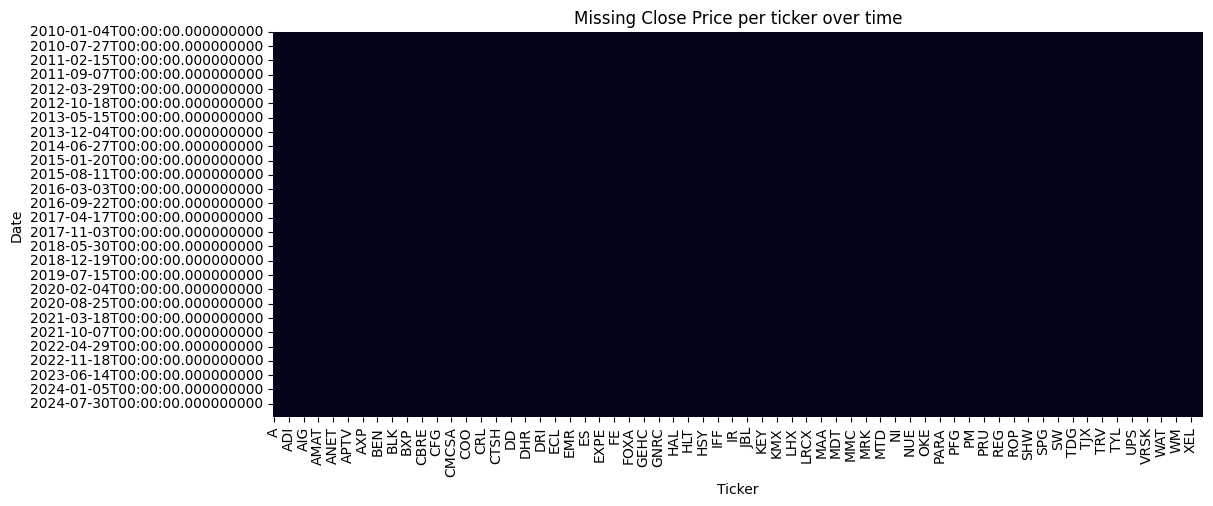

In [ ]:
#Visualizes data quality and helps identify problematic tickers.
missing_heatmap = df_long_filled.pivot(index='Date',columns='Ticker',values='Close').isna()
plt.figure(figsize=(12,5))
sns.heatmap(missing_heatmap, cbar=False)
plt.title("Missing Close Price per ticker over time")
plt.show()

In [ ]:
"""
✅ Why Use Close Price? Why not not other colunmns in this?????????
 Close Price is the Most Critical Price
Almost all financial modeling, forecasting, and ML predictions use the daily closing price.

Your goal:
a. Predict the next day’s closing price
b. Forecast future closing prices
So Close is the most relevant signal.

Close Price is Always Available If Data is Valid.If Close is missing, very likely entire row is missing for that ticker on that date.It Represents Market Sentiment at End of Day
Unlike Open (often volatile), Close reflects final investor consensus.Most technical indicators (e.g., moving averages, RSI) use Close.

Can You Use Other Fields Like Volume?
Yes, but:
Use Volume if you're analyzing liquidity or trading activity.
Use Open, High, Low if you want to explore data availability in general, but Close is the cleanest proxy for data presence.

"""

#Plot Price Trends for Key Tickers (Apple Inc.,Google,Tesla)

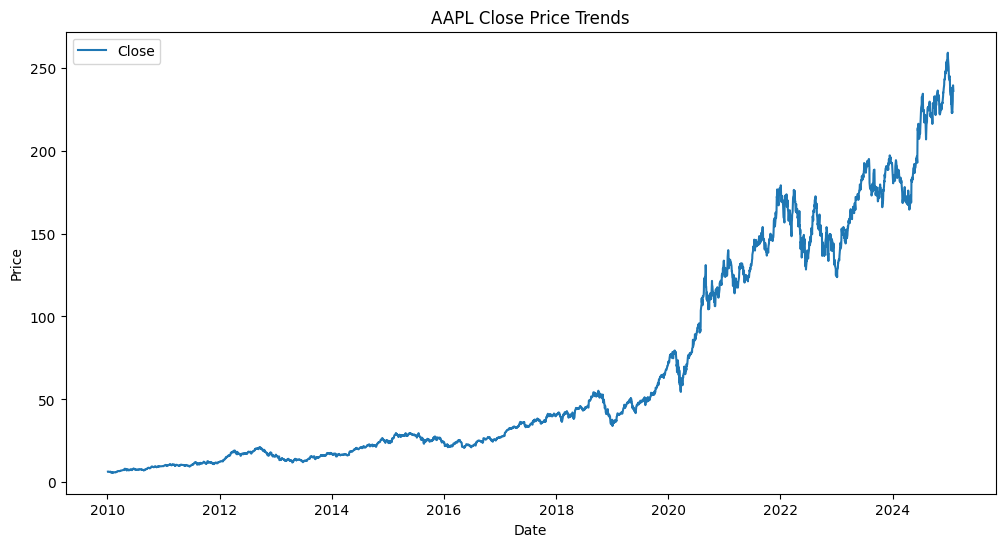

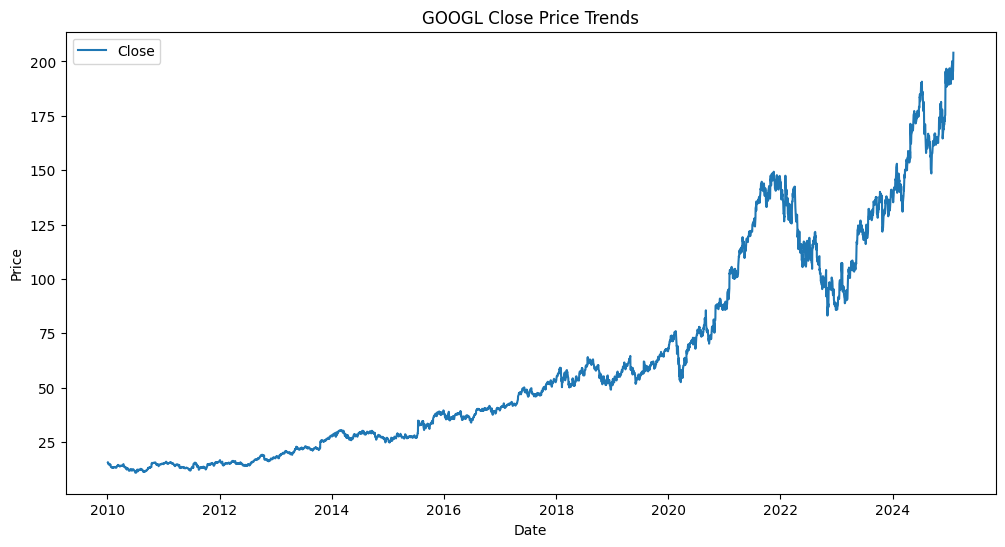

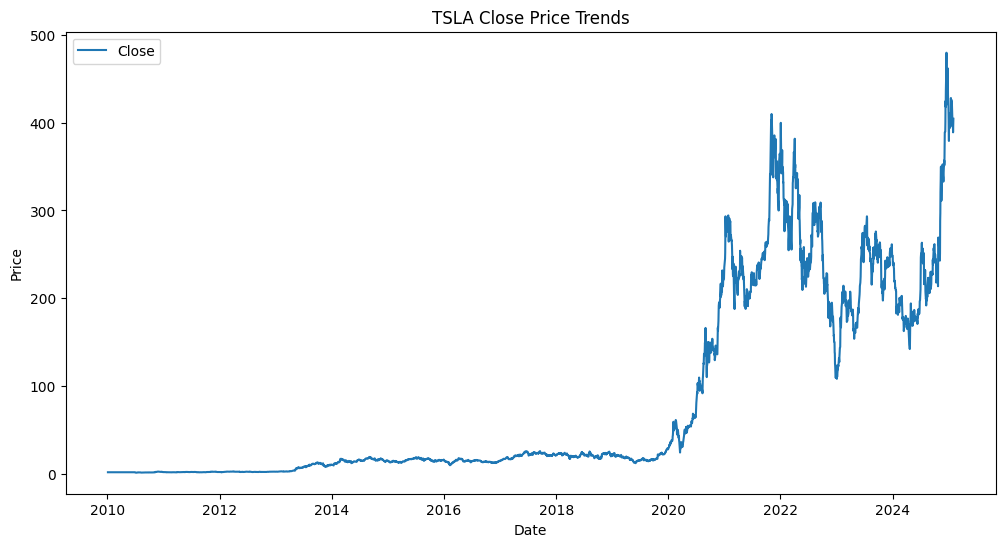

In [ ]:
#To see if trends are rising, seasonal, or volatile.
for ticker in ['AAPL','GOOGL','TSLA']:
  df_t = df_long_filled[df_long_filled['Ticker'] == ticker]
  plt.figure(figsize=(12, 6))
  plt.plot(df_t['Date'], df_t['Close'], label='Close')
  plt.title(f"{ticker} Close Price Trends")
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.legend()
  plt.show()

#Volatility Analysis (Standard Deviation, Returns)





In [ ]:
# Daily returns and volatility
df_volatility = df_long_filled.copy()
df_volatility['Return'] = df_volatility.groupby('Ticker')['Close'].pct_change()

print(df_volatility.head(10))

        Date Ticker      Close       High        Low       Open     Volume  \
0 2010-01-04      A  20.016031  20.227063  19.907317  20.073585  3815561.0   
1 2010-01-05      A  19.798611  19.964878  19.670712  19.958484  4186031.0   
2 2010-01-06      A  19.728262  19.824185  19.670707  19.728262  3243779.0   
3 2010-01-07      A  19.702684  19.709079  19.504442  19.683498  3095172.0   
4 2010-01-08      A  19.696289  19.728265  19.440495  19.593971  3733918.0   
5 2010-01-11      A  19.709070  19.856152  19.613147  19.747439  4781579.0   
6 2010-01-12      A  19.472466  19.600363  19.325382  19.542809  2871073.0   
7 2010-01-13      A  19.625940  19.683494  19.216668  19.485253  3418949.0   
8 2010-01-14      A  19.920105  19.977658  19.504436  19.561991  6163782.0   
9 2010-01-15      A  19.459679  20.054406  19.395729  19.964877  4626681.0   

     Return  
0       NaN  
1 -0.010862  
2 -0.003553  
3 -0.001296  
4 -0.000325  
5  0.000649  
6 -0.012005  
7  0.007882  
8  0.014989  
9

In [ ]:
"""
1.Why use groupby('Ticker')?
Ans:Because you want to compute returns separately for each stock. If you don’t group by Ticker, it’ll compute returns across different tickers, which is incorrect.

2.How this pct_change() is calculated?
Ans:
Date	Ticker	Close
2023-01-01	AAPL	100
2023-01-02	AAPL	105
2023-01-03	AAPL	102

The percentage changes would be:
Date	Return
2023-01-01	NaN (no prev)
2023-01-02	(105-100)/100 = 0.05 or 5%
2023-01-03	(102-105)/105 = -0.0286 or -2.86%

"""

Top 10 Most Volatile Stocks:
Ticker
ENPH    0.046519
SMCI    0.037749
TSLA    0.035553
AMD     0.035090
BLDR    0.034811
FSLR    0.033644
APA     0.031500
NFLX    0.031461
NCLH    0.031296
FCX     0.031094
Name: Return, dtype: float64


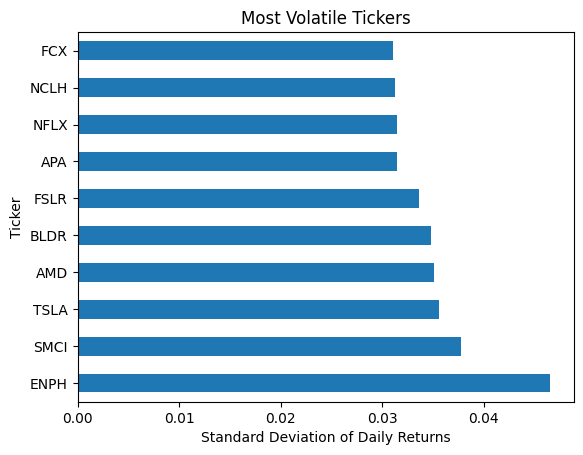

In [ ]:
# Plot top volatile stocks which helps you choose stocks with enough movement for prediction.
vol_stats = df_volatility.groupby('Ticker')['Return'].std().sort_values(ascending=False)
print("Top 10 Most Volatile Stocks:")
print(vol_stats.head(10))
vol_stats.head(10).plot(kind='barh', title='Most Volatile Tickers')
plt.xlabel("Standard Deviation of Daily Returns")
plt.show()

#Correlation Between Tickers (Wide Format)

In [ ]:
#using close price only
df_close = df_wide_from_long[[col for col in df_wide_from_long.columns if col.endswith('_Close')]]
corr_matrix = df_close.corr()

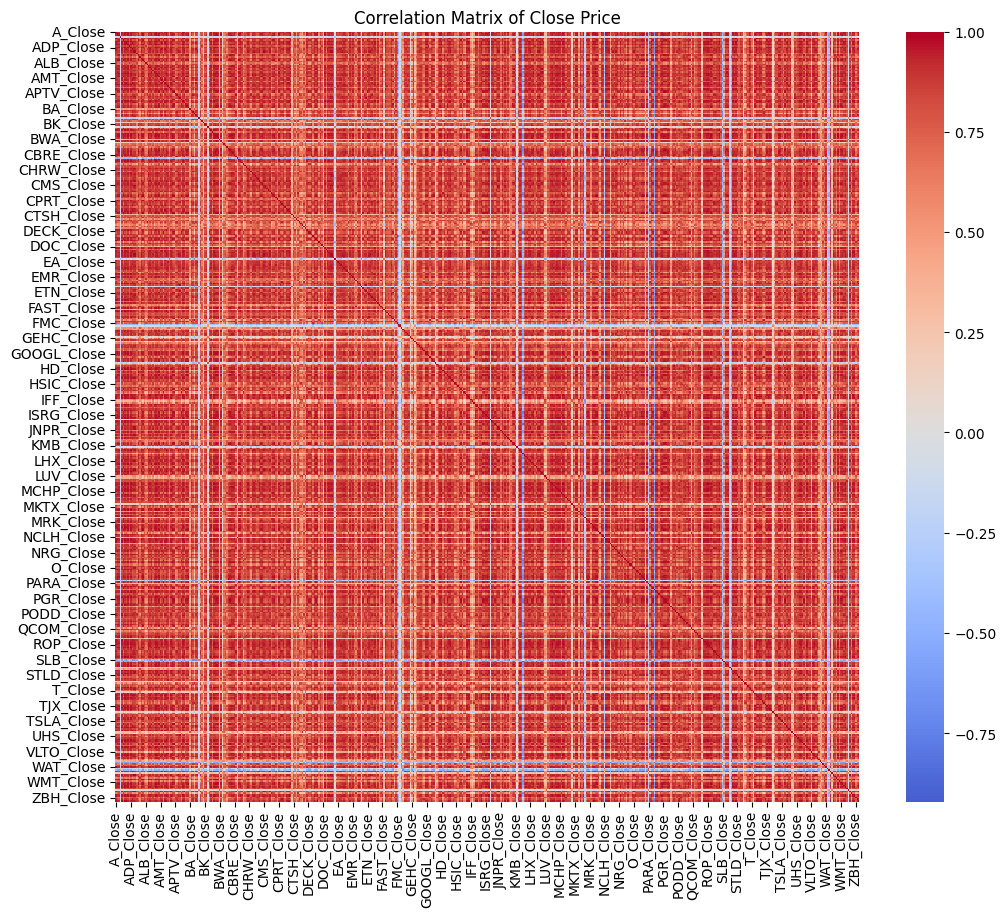

In [ ]:
#To Understand relationships between stocks — helps in feature engineering or multi-stock strategies.
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix,cmap="coolwarm",center=0,annot=False)
plt.title("Correlation Matrix of Close Price")
plt.show()

#Trend Classification (Creating Binary Label)

In [ ]:
#Creates binary labels for classification models.
df_trend =df_volatility.copy()
df_trend['Close_next'] = df_trend.groupby('Ticker')['Close'].shift(-1)
df_trend['Target_Trend'] = (df_trend['Close_next'] > df_trend['Close']).astype(int)

In [ ]:
"""
   1.Why we are doing this trend classification?

    Ans:You're building a classification model to answer a simple question:
    🔮 Will the stock go up tomorrow or not?
    So you want to create binary labels (0 or 1) for machine learning:
    1 → If tomorrow's Close price is higher than today → UP trend
    0 → If tomorrow’s Close price is equal or lower → DOWN or FLAT trend

    This is called trend classification — useful for:Logistic Regression,Decision Trees, Random Forests,
    Neural nets for classification,Strategy backtesting (buy/sell signals)

   2.What this shift(-1) is doing?

  Ans: 🔁 .shift(-1) means:“Take the value from the next row (i.e., next date) in the group.”So for each Ticker:

    Date	Close	Close_next (shift(-1))

    2023-01-01	100	105
    2023-01-02	105	102
    2023-01-03	102	NaN (no next day)

    You now have both today’s and tomorrow’s price — allowing you to compare.

"""

In [ ]:
print(df_trend[['Date', 'Ticker', 'Close', 'Close_next', 'Target_Trend']].dropna().head())

        Date Ticker      Close  Close_next  Target_Trend
0 2010-01-04      A  20.016031   19.798611             0
1 2010-01-05      A  19.798611   19.728262             0
2 2010-01-06      A  19.728262   19.702684             0
3 2010-01-07      A  19.702684   19.696289             0
4 2010-01-08      A  19.696289   19.709070             1


#Weekly / Monthly Aggregation
#For forecasting (e.g., 7-day or monthly average):

In [ ]:
#Smoother trends help forecast long horizons.
df_weekly = df_long_filled.copy()
df_weekly['Week'] = df_weekly['Date'].dt.to_period('W').dt.to_timestamp()

In [ ]:
"""
1. dt.to_period('W')
Converts each daily date into a weekly period (e.g., "2024-06-10/2024-06-16").
This creates a Period object that represents the week that the date falls in.
Example:
'2024-06-12' → Period('2024-06-10/2024-06-16', 'W-MON') (week starting on Monday).

2. dt.to_timestamp()
Converts that weekly period back to a timestamp, typically the start of the week.
  If your Date column has:
  Date
  2024-06-10
  2024-06-11
  2024-06-12
  2024-06-17

  Then df_weekly['Week'] will be:
  Week
  2024-06-10
  2024-06-10
  2024-06-10
  2024-06-17

  All the first 3 dates are grouped under the same week starting from 2024-06-10.

✅ Why use this?
To resample or aggregate data by week:Weekly average closing price,Weekly returns,Weekly volume, etc.

"""

In [ ]:
weekly_avg=df_weekly.groupby(['Week','Ticker'])[['Close']].mean().reset_index()

In [ ]:
"""
1.Why compute weekly averages?

Ans:To smooth out daily volatility. Useful for plotting trends, modeling at lower frequency. Ideal for forecasting models with weekly granularity.

groupby(['Week', 'Ticker']) This groups your data by: Week: the start of each week (e.g., 2024-06-10) Ticker: stock symbol (e.g., AAPL, MSFT)
 🔁 So for each (Week, Ticker) combination, you're isolating all rows (i.e., all trading days of that week for that stock).

[['Close']].mean() Within each (Week, Ticker) group, take the mean closing price.
For example, if you had: AAPL prices in one week = 180, 182, 185 It computes: Weekly Average=(180+182+185)/3=182.33

.reset_index() After groupby, you get a MultiIndex dataframe. reset_index() flattens it into a normal DataFrame with columns:Week,Ticker,Close (weekly average)
✅ Resulting DataFrame weekly_avg will look like: Week Ticker Close 2024-06-10 AAPL 182.33 2024-06-10 MSFT 316.92 2024-06-17 AAPL 185.75
"""

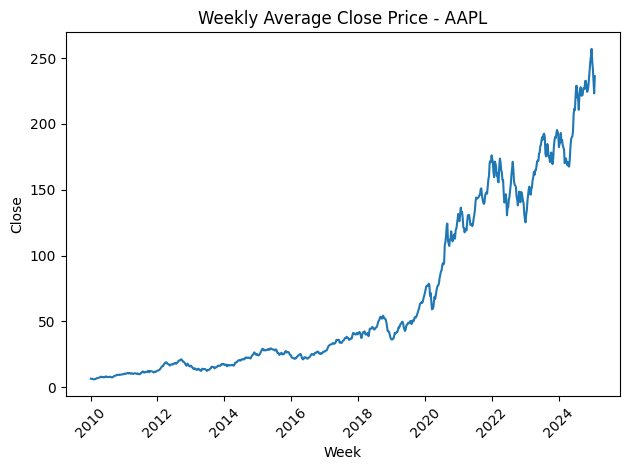

In [ ]:
sns.lineplot(data=weekly_avg[weekly_avg['Ticker'] == 'AAPL'], x='Week', y='Close')
plt.title('Weekly Average Close Price - AAPL')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
"""Code	Why It’s Used
plt.xticks(rotation=45)	Makes date labels readable on x-axis
plt.tight_layout()	Prevents label cutoff, improves plot layout

Both are best practices for making your plots look polished and professional.
"""

#Stationarity Check (for Time Series Models)
✅ Goal:
Check if AAPL's closing price time series is stationary or not using the ADF test (Augmented Dickey-Fuller test).

🧠 What is "stationarity"?
A time series is stationary if:
Its mean, variance, and autocorrelation stay constant over time.
No clear trend, seasonality, or changing variance.

📌 ARIMA requires stationary data. If data is non-stationary, we must transform it (usually by differencing).

🔎 What these mean:
Metric	Value	Interpretation
ADF Statistic	+1.24	Not strongly negative → indicates likely non-stationary
p-value	0.996	Very high → cannot reject the null hypothesis

❗ ADF Hypothesis Test:
Null hypothesis (H₀): The time series is not stationary (has a unit root).
Alternative (H₁): The time series is stationary.
With a p-value of 0.996, we fail to reject the null hypothesis → your time series is non-stationary.

| Step           | Purpose                                        |
| -------------- | ---------------------------------------------- |
| `adfuller()`   | Tests if a time series is stationary           |
| ADF Statistic  | More negative = more likely stationary         |
| p-value > 0.05 | Not stationary → you should apply differencing |
| Next step      | Use `.diff()` and test again                   |



In [ ]:
#ARIMA/LSTM need stationary data; check if differencing is needed.
from statsmodels.tsa.stattools import adfuller

ts =df_aapl['Close'].dropna()
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.238516
p-value: 0.996241


#Performing Differencing time series to make it stationary

🔍 What This Means:
Metric	Value	Interpretation
ADF Statistic	-14.67	Strongly negative → strong evidence for stationarity
p-value	~0.0000000000000000000000000328	Way below 0.05 → reject the null hypothesis

📌 Conclusion:
✅ Your differenced closing price series for AAPL is now stationary.
This makes it suitable for:
ARIMA modeling (ARIMA expects stationary input)
Feature engineering (like returns)
LSTM with optional differencing (depends on how you model sequences)


In [ ]:
df_aapl['Close_diff'] = df_aapl['Close'].diff().dropna()
result = adfuller(df_aapl['Close_diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -14.669538510068733
p-value: 3.2833990772010215e-27


/tmp/ipython-input-70-3794759654.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aapl['Close_diff'] = df_aapl['Close'].diff().dropna()


In [ ]:
"""✅ Why Do We Need Stationary Data for ARIMA and Sometimes LSTM?

🚦 What Is Stationary Data Again?
A time series is stationary when:
Its mean, variance, and correlation structure do not change over time.
It doesn't trend upward or downward, or have seasonal spikes.

📉 Why Does ARIMA Require Stationary Data?
ARIMA (AutoRegressive Integrated Moving Average) is based on statistical assumptions like:
| Component           | What it Does                           | Requires Stationarity?           |
| ------------------- | -------------------------------------- | -------------------------------- |
| AR (AutoRegressive) | Models correlation with past values    | ✅ Yes                            |
| MA (Moving Average) | Models correlation with past errors    | ✅ Yes                            |
| I (Integrated)      | Differencing to make series stationary | ❌ No — it *creates* stationarity |


📌 Key Point:
ARIMA assumes that the underlying time series is predictable by its past values.

👉 If the data is non-stationary:
Past relationships between values (lags) change over time.
The model will produce inaccurate forecasts.
Residuals may not be white noise (model is mis-specified).

🧪 A non-stationary series violates core assumptions of ARIMA.
That’s why we difference the data to make it stationary before modeling.

🧠 What About LSTM (Deep Learning)?
LSTM (Long Short-Term Memory) is more flexible than ARIMA:
It can learn non-linear trends and handle non-stationary data better.
However, training on non-stationary data can:
Make learning slower
Increase the chance of overfitting
Reduce forecast stability

👉 Best practice with LSTM:
Differencing or normalizing helps remove trends and scale problems.
Makes it easier for the model to focus on patterns, not just scale.

"""

"✅ Why Do We Need Stationary Data for ARIMA and Sometimes LSTM?\n\n🚦 What Is Stationary Data Again?\nA time series is stationary when:\nIts mean, variance, and correlation structure do not change over time.\nIt doesn't trend upward or downward, or have seasonal spikes.\n\n📉 Why Does ARIMA Require Stationary Data?\nARIMA (AutoRegressive Integrated Moving Average) is based on statistical assumptions like:\n| Component           | What it Does                           | Requires Stationarity?           |\n| ------------------- | -------------------------------------- | -------------------------------- |\n| AR (AutoRegressive) | Models correlation with past values    | ✅ Yes                            |\n| MA (Moving Average) | Models correlation with past errors    | ✅ Yes                            |\n| I (Integrated)      | Differencing to make series stationary | ❌ No — it *creates* stationarity |\n\n\n📌 Key Point:\nARIMA assumes that the underlying time series is predictable by its p

#Save Cleaned Versions dataframes

In [ ]:
df_clean.to_csv('/content/drive/My Drive/Stock Price Prediction Project/DataSet/stock_data_wide.csv', index=False)

In [ ]:
df_long_filled.to_csv('/content/drive/My Drive/Stock Price Prediction Project/DataSet/stock_data_long_filled.csv', index=False)

In [ ]:
df_nonempty.to_csv('/content/drive/My Drive/Stock Price Prediction Project/DataSet/stock_data_long_nonempty.csv', index=False)